# GEOG 5160 6160 Lab 06

In this lab, we will introduce **scikit-learn**, a toolkit for machine learning in Python. This provides a standard interface managing a machine learning workflow, including setting up training and testing data, running different algorithms and evaluating the models. 

Let's start by importing the packages that we will need

In [1]:
import numpy as np
import pandas as pd
import sklearn

We'll start now by loading the housing data in to a Pandas DataFrame, and using `shape` to look at the size of the dataset. 

In [2]:
housing = pd.read_csv("../datafiles/housing.csv")
housing.shape

(20640, 10)

Now, use the `describe()` method to get an overview of the different variables that are included. 

In [3]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Before starting building models, we need to check and clean the data. Some things that we may want to check for are:

- missing values
- variable conversions
- outliers

Let's check to see which of the features contain missing values. The following code uses a couple of methods linked together. First `isna()` to check each value in the data frame to see if it is a missing value and flag it as `True` or `False`. Then we use `any()` which returns `True` of `False` for each column if there is at least one `True` (i.e. missing) values in that column:

In [4]:
housing.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

This tells us that the only column with missing values is `total_bedrooms`. We'll now remove these using the `dropna()` method to remove each row with a missing value:

In [5]:
housing = housing.dropna()
housing.shape

(20433, 10)

### Data visualization

Next, we'll visualize some of the data, starting with a quick map of the locations, then the median house values. First, we load `matplotlib` and set it to run inline in the notebook. 

In [6]:
%matplotlib inline
import matplotlib as plt

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

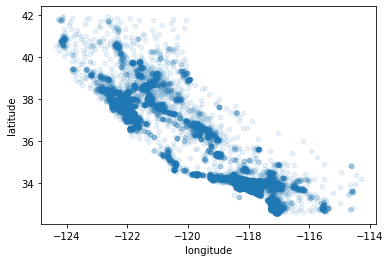

In [7]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)

To make a better plot of the house values, we'll use `GeoPandas`, a package that extends `Pandas` to include spatial information (you'll need to install this if you have not done so already). Now load the package, and use it to read in the California border shapefile:

In [8]:
import geopandas as gpd
ca_bnd = gpd.read_file("../datafiles/ca/ca.shp")
ca_bnd.crs

<Geographic 2D CRS: GEOGCS["GRS 1980(IUGG, 1980)",DATUM["D_unknown",SP ...>
Name: GRS 1980(IUGG, 1980)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: D_unknown
- Ellipsoid: GRS80
- Prime Meridian: Greenwich

The last line of code prints the coordinate reference system (`crs`) for the California border polygon. As the housing data is in WGS84, we can convert the polygon to this use the `to_crs()` method:

In [9]:
ca_bnd = ca_bnd.to_crs(epsg=4326)
ca_bnd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Next, we'll create a GeoPandas DataFrame from the housing data

In [10]:
housing_gpd = gpd.GeoDataFrame(housing, 
                               geometry=gpd.points_from_xy(housing.longitude, housing.latitude), 
                               crs=ca_bnd.crs)

Now let's plot the border, then add points for each location and use the `median_house_value` to set the color. Note that we first create a `base` layer, then use this when plotting the points. The `column` argument allows you to set which of the variables you want to plot:

In [ ]:
base = ca_bnd.plot(figsize = (6.5, 6.5), edgecolor="black", facecolor="None")
housing_gpd.plot(ax = base, column = 'median_house_value', markersize = 10);

And you should be able to clearly see the areas with high values around Los Angeles and the Bay Area. Now let's visualize the variables as a set of histograms:

In [ ]:
housing.hist(bins = 50, figsize = (20, 15))

In [ ]:
housing['avg_rooms'] = housing.total_rooms / housing.households
housing['bedroom_ratio'] = housing.total_bedrooms / housing.total_rooms

As a last step here, we'll remove any observations where the house value is greater than $500K. As the dataset is capped here, these will bias our model 

In [ ]:
housing2 = housing[housing.median_house_value <= 500000]

## **scikit-learn**

We'll now introduce **scikit-learn** by using it to build a simple linear regression model between the median house values and all other variables. **scikit-learn** has a standardized API for running most algorithms, and the steps we are going to take here are largely the same for any of the approaches we will look at over the next couple of weeks:

- Form a data set of features (or covariates)
- Form a data set of labels (or responses)
- Split into a *training* and *testing* dataset
- Build or train a model with the training features and labels
- Predict using the testing features
- Compare the predicted test labels to the observed test labels
- Calculate a score indicating the model performance

### Features and labels

Previous versions of **scikit-learn** were not able to use Pandas DataFrames directly, and these had to be converted to NumPy numerical arrays. Recent versions however, allow to use Pandas (this is still converted internally to a NumPy array). For our first step then, we simply need to create 

For our first model, we're only going to use a subset of the variables representing building characteristics (average number of rooms, bedroom ratio and age), so we'll create a new DataFrame with these, and a second with the house values

In [ ]:
X = housing[['avg_rooms', 'bedroom_ratio', 'housing_median_age']]
y = housing['median_house_value']

### Training and testing sets

Next, we'll create a training and testing dataset. There are various approaches to do this, but for now, we'll simply use a holdout method, with 75% of the data in the training set and 25% in testing. **scikit-learn** has a function (`train_test_split`) to help with this. The argument `train_size` controls the size of the training set (here 75%). You can also set this to an integer value, in which case it will random select that number of observations for training. You can also use `test_size` if you'd prefer to control the size of the testing set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.75)

Let's check the dimensions of our new datasets

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Giving approximately 15000 samples in training and 5000 in testing. Note that the `X` arrays have three columns representing the features, and the `y` arrays have only 1

### Training a model

We're going to use the linear regression function from **scikit-learn** (`LinearRegression()`). This is one of a set of linear models, so start by loading that module. For any scikit model, we first instantiate the model by calling the function name, then fit the model by (not too surprisingly) calling the `fit` method with the training data 

In [ ]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)

Having fit the model, we can check the results. First, we'll make a table of the regression coefficients:

In [ ]:
print(lin_reg.coef_)

As this is just an array of coefficients, we can make this into a table to show the corresponding features:

In [ ]:
cdf = pd.DataFrame(lin_reg.coef_, X_train.columns, columns=['Coefficients'])
print(cdf)

Note that the coefficients do not include the intercept, so to show this:

In [ ]:
print(lin_reg.intercept_)

The `score()` method will return the coefficient of determination ($R^2$). This is pretty low for this model, and in the exercise you'll look at ways to improve this.

In [ ]:
print(lin_reg.score(X_train, y_train))

### Predicting with the test set

Next step is to predict the labels or outcomes for the testing set. Prediction in **scikit-learn** is pretty straightforward, we simply call the `predict()` method on our trained model, and pass the `X_test` DataFrame.

In [ ]:
y_test_pred = lin_reg.predict(X_test)

Now we can plot the predicted house values against the observed value.

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_test_pred,  color='black')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.show()

Note that there is a large amount of scatter on this plot (ideally, the points would fall along a 1:1 line). One thing to note here is that there are several districts where the house prices are predicted to be negative. This is obviously incorrect (unless they are paying people to take a house). Transforming the outcome variable (e.g. log transformation) would help avoid this problem. 

In addition to this visualization, we also need to quantify this using a performance score. This will eventually allow us to compare different learning algorithms or different setups of the same algorithm to see which is best. Not too surprisingly then, **scikit** comes with a whole suite of different metrics that we can use. To see the full list, go here: https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
from sklearn.metrics import mean_squared_error
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

We can easily swap this out for different metrics, e.g. the mean absolute error:

In [ ]:
from sklearn.metrics import mean_absolute_error
print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test, y_test_pred))

## Cross-validation with **scikit-learn**

So far, we have built and tested our model on a single split of the data (the hold-out method). However, if the training and testing datasets are not well set up, the estimates of model performance can be biased. There are several more exhaustive resampling strategies that can be used instead, and we will implement one of these now. This link provides a list of available strategies: https://scikit-learn.org/stable/modules/cross_validation.html

We'll just use one of the simplest, but exhaustive approaches; $k$-fold cross-validation. This splits the data into $k$ groups and loops across these. In each iteration, one group is held out as test data and the other $k-1$ are used as training data. A performance score is then estimated for each fold. **scikit** has an easy function to run this (and other approaches on a previously set up model; `cross_val_score`. 

In the following code, we first define our cross-validation strategy as a 5-fold approach, then use the following input to `cross_val_score`:

- The model object `lin_reg`
- The set of features and labels (note we use the full set as this will divide the data up for us into training and testing for each fold)
- The cross-validation strategy. The default here is a 5-fold cross-validation but being able to define our own strategy will be useful later
- The performance score (this uses the **scikit** full name)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
# define model evaluation method
cv = KFold(n_splits=5)

scores = cross_val_score(lin_reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

We can now print out the set of cross-validated scores (as well as calculate the mean RMSE)

In [ ]:
print(-scores)
print(np.mean(-scores))

## Changing model

We're going to be looking a wide range of different algorithms for machine learning over the next few weeks. This section is just designed to show how easy it is to switch out the method you are using to try a different approach. Here, we'll try using a penalized linear model, the Lasso. To test this, we simply need to import the relevant module from `sklearn.linear_model`, instantiate and run the same cross-validation strategy we previously defined. In this case, there is little improvement with this new algorithm.

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 1)
lasso_reg.fit(X_train, y_train)
scores = cross_val_score(lasso_reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')
print(np.mean(-scores))
#print(lasso_reg.alpha_)

## Exercise

Use a word document or jupyter notebook to record your answers and output. Assignments, to include either the word document and notebook, should be submitted to Canvas before class on Monday, XXXXXX XX. Ensure your assignment has been saved using the following naming convention: Lab06_lastname_script and Lab06_lastname_report.

As we noted during the lab, our original model some odd effects, and had pretty poor predictive power. We'll try to improve on this by adding in extra features. The following code recreates the two DataFrames containing the features and labels, but includiing a larger set:

In [ ]:
X = housing[['avg_rooms', 'bedroom_ratio', 'housing_median_age',
            'population', 'households', 'median_income']]
y = housing['median_house_value']

For the exercise, you need to 

1. Remake the basic linear model with this new dataset. Provide the output from the `summary()` function (either as a screenshot or copy-paste) [1]
2. Make a new task for machine learning this new dataset [1]
3. Repeat the resampling strategy with the new task, but with a 10-fold cross validation (i.e. `folds = 10`). Provide the set of 10 RMSE values and the aggregate RMSE [2]
4. Comment on whether you think this new model is better or worse at predictions than the mode you built in the lab [1]